In [1]:
# IMPORTING POTENTIALLY IMPORTANT LIBRARIES
import numpy
import pandas
import seaborn
import matplotlib.pyplot as PyPlot
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
def CustomMetrics(InputDataframe):
    
    """
    The function serves to consolidate commonly necessary metrics into one dataframe. Both the input and output of the function is a Pandas dataframe.
    Specifically, the function will return :
            
        * The datatype of your input dataframe's column
        * A boolean flag of whether or not there are missing values in the in the input dataframe
        * The number of null values that exist in each of the input columns
        * The number of unique values in each of the input columns
    """
    
    DataframeMetrics = pandas.DataFrame(index=InputDataframe.columns,columns='ColumnDatatypes #UniqueValues NullValuesPresent #NullValues'.split())
    Columns = list(InputDataframe.columns)
    
    for Values in Columns:        
        DataframeMetrics['ColumnDatatypes'][Values] = InputDataframe[Values].dtypes
        DataframeMetrics['#UniqueValues'][Values] = InputDataframe[Values].nunique()
        DataframeMetrics['#NullValues'][Values] = InputDataframe[Values].isnull().sum()
        DataframeMetrics['NullValuesPresent'][Values] = InputDataframe[Values].isnull().values.any()
    
    print('The dimensions of the input dataframe are: {} rows by {} columns.'.format(len(InputDataframe.index), len(InputDataframe.columns)))
    return DataframeMetrics

## READING & PRE-PROCESSING SECTION

In [3]:
# READ IN THE YELP REVIEW DATASET & SHOW FIRST FEW ROWS TO GAIN INITIAL INSIGHTS
YelpReviews = pandas.read_csv('yelp.csv')
YelpReviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
# CALLING THE CUSTOM FUNCTION TO GET A MORE DETAILED VIEW OF THE DATA
# HELPS IN IDENTIFYING THE COLUMNS THAT DON'T HELP IN CAPTURING VARIANCE IN THE DATA
CustomYelpMetrics = CustomMetrics(YelpReviews)
CustomYelpMetrics

The dimensions of the input dataframe are: 10000 rows by 10 columns.


,ColumnDatatypes,#UniqueValues,NullValuesPresent,#NullValues
business_id,object,4174,False,0
date,object,1995,False,0
review_id,object,10000,False,0
stars,int64,5,False,0
text,object,9998,False,0
type,object,1,False,0
user_id,object,6403,False,0
cool,int64,29,False,0
useful,int64,28,False,0
funny,int64,29,False,0


In [5]:
# CONVERT THE COLUMNS THAT ARE OF THE WRONG DATATYPE
YelpReviews['text'] = YelpReviews['text'].astype(str)
YelpReviews['date'] = pandas.to_datetime(YelpReviews['date'])
CustomYelpMetrics = CustomMetrics(YelpReviews)
CustomYelpMetrics

The dimensions of the input dataframe are: 10000 rows by 10 columns.


,ColumnDatatypes,#UniqueValues,NullValuesPresent,#NullValues
business_id,object,4174,False,0
date,datetime64[ns],1995,False,0
review_id,object,10000,False,0
stars,int64,5,False,0
text,object,9998,False,0
type,object,1,False,0
user_id,object,6403,False,0
cool,int64,29,False,0
useful,int64,28,False,0
funny,int64,29,False,0


In [6]:
# DROP THE COLUMNS THAT HAVE EITHER RANDOMLY GENERATED VALUES OR VERY LITTLE VARIANCE
# NECESSARY FOR REDUCING THE ISSUE OF DIMENSIONALITY IN ANY FUTURE MODELING THAT WE MIGHT WANT TO DO
YelpReviews.drop(labels = ['business_id', 'review_id', 'user_id', 'type'], axis = 1, inplace = True)
YelpReviews

,date,stars,text,cool,useful,funny
0,2011-01-26,5,My wife took me here on my birthday for breakf...,2,5,0
1,2011-07-27,5,I have no idea why some people give bad review...,0,0,0
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,0,0
...,...,...,...,...,...,...
9995,2012-07-28,3,First visit...Had lunch here today - used my G...,1,2,0
9996,2012-01-18,4,Should be called house of deliciousness!\n\nI ...,0,0,0
9997,2010-11-16,4,I recently visited Olive and Ivy for business ...,0,0,0
9998,2012-12-02,2,My nephew just moved to Scottsdale recently so...,0,0,0


## DATA EXPLORATION SECTION

In [7]:
# CHECKING TO SEE IF THERE ARE ANY IMMEDIATE CORRELATIONS THAT WE CAN IDENTIFY
YelpReviews.corr()

,stars,cool,useful,funny
stars,1.000000,0.052555,-0.023479,-0.061306
cool,0.052555,1.000000,0.887102,0.764342
useful,-0.023479,0.887102,1.000000,0.723406
funny,-0.061306,0.764342,0.723406,1.000000


In [8]:
# lOOKING THROUGH THE STATISTICAL VALUES OF THE NUMERICAL COLUMNS
YelpReviews.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [9]:
# APPENDING A NEW COLUMN TO THE DATASET IN ORDER TO ANALYZE A POTENTIAL RELATIONSHIP BETWEEN 
# THE STARS ASSIGNED AND THE LENGTH OF THE REVIEW
WordCount = []
for Reviews in YelpReviews['text']:
    WordCount.append(len(Reviews.split()))
YelpReviews['WordCount'] = WordCount

<AxesSubplot:xlabel='stars', ylabel='Count'>

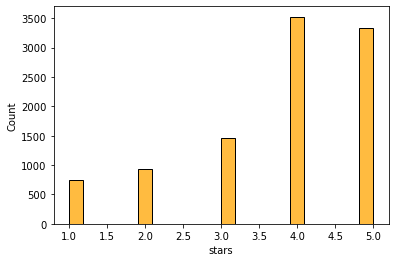

In [10]:
# CHECK TO SEE IF THERE IS AN EQUAL DISTRIBUTION OF THE NUMBER OF STAR ASSIGNMENTS
seaborn.histplot(YelpReviews['stars'], color = 'orange')

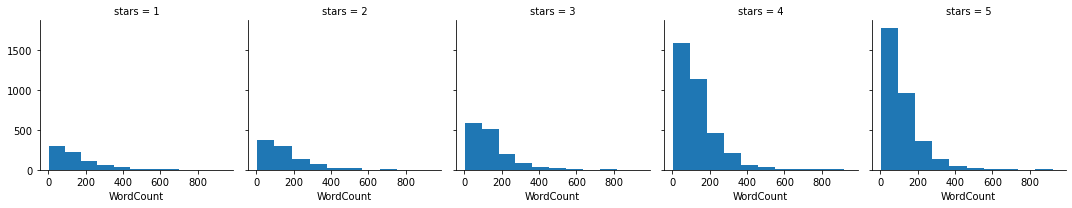

In [11]:
# PLOT A SIMPLE SET OF GRAPHS TO DETERMINE ANY POTENTIAL CONNECTION BETWEEN THE WORD COUNT & NUMBER OF STARS ASSIGNED
Words_Stars = seaborn.FacetGrid(YelpReviews, col = 'stars')
Words_Stars.map(PyPlot.hist, 'WordCount')

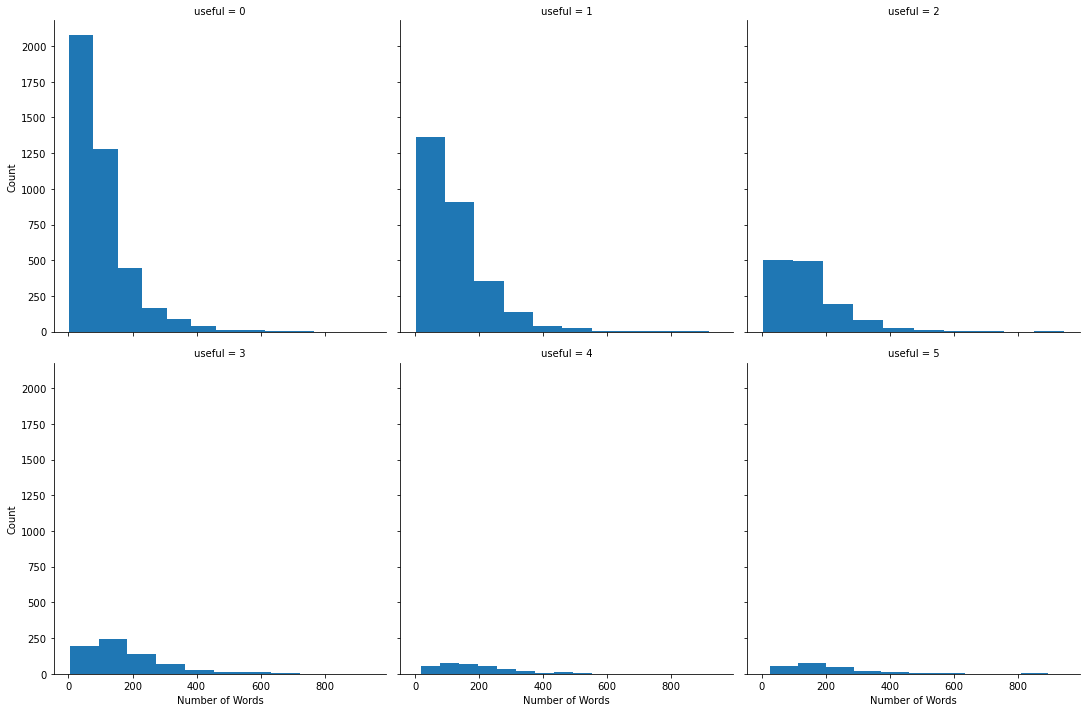

In [16]:
# REMOVE THE OUTLIERS THAT SIT OUTSIDE OF THE LOWER & UPPER FENCE VALUES.
NoOutliers = YelpReviews[YelpReviews['useful'].between(YelpReviews['useful'].quantile(.05), YelpReviews['useful'].quantile(.95))]
Words_Useful = seaborn.FacetGrid(NoOutliers, col = 'useful', height = 5, aspect = 1, col_wrap = 3)
Words_Useful.map_dataframe(PyPlot.hist, 'WordCount')
Words_Useful.set_axis_labels("Number of Words", "Count")

In [ ]:
CustomMetrics(NoOutliers)

## MODELING & RESULTS SECTION

In [ ]:
# SELECT THE REVIEWS THAT WERE ASSOCIATED WITH THE BEST AND WORST RATING IN THE DATASET
YelpReviews2 = YelpReviews[(YelpReviews.stars == 1) | (YelpReviews.stars == 5)]

# ESTABLISH THE TARGET AND ATTRIBUTES THAT WILL BE FED INTO THE MODEL TRAINING
Reviews = YelpReviews2['text']
StarRating = YelpReviews2['stars']

# CREATE VECTORIZER & MULTINOMIAL NAIVE-BAYES OBJECTS
Vectorizer = CountVectorizer()
NBClassifier = MultinomialNB()

# VECTORIZE THE TEXT COLUMN USING THE VECTORIZER OBJECT
Reviews = Vectorizer.fit_transform(Reviews)

# SPLIT THE DATASET INTO TRAINING & TESTING DATASETS
XTrain, XTest, YTrain, YTest = train_test_split(Reviews, StarRating, test_size = 0.4, random_state = 201)

# FIT THE MODEL & PREDICT ON THE TEST DATA
NBClassifier.fit(XTrain, YTrain)
RatingPredictions = NBClassifier.predict(XTest)

# OUTPUT THE RESULTS TO SEE THE EFFECTIVENESS OF THE MODELING
print(confusion_matrix(YTest, RatingPredictions), '\n')
print('\n', classification_report(YTest, RatingPredictions))

In [ ]:
# GET THE FREQUENCY OF PREDICTIONS TO BETTER UNDERSTAND THE PREDICTING TENDENCIES OF THE MODEL
numpy.unique(RatingPredictions, return_counts = True)

In [ ]:
# CONFUSION MATRIX METRICS FROM THE MODEL
NBConfusionMatrix = confusion_matrix(YTest, RatingPredictions)
ConfusionMap = ConfusionMatrixDisplay(confusion_matrix=NBConfusionMatrix, display_labels=NBClassifier.classes_)
ConfusionMap.plot()